# Step 2. Train the model

Using the data created from Step 1, here we are going to build a simple benchmark model (simple neural network) to evaluate the stock return predictability.

In [88]:
# data 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [3]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
data_dir = 'data' # the folder we will use for storing data
name = 'train.csv'

In [5]:
# specify where to upload in S3
prefix = 'stock-price-predictor'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-ap-northeast-1-165829362107/stock-price-predictor


In [97]:
!pygmentize source_simpleNet/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        '''Defines layers of a neural network.
           :param input_dim: Number of input features
           :param hidden_dim: Size of hidden layer(s)
           :param output_dim: Number of outputs
         '''
        super(SimpleNet, self).__init__()
        # defining 2 linear layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.drop = nn.Dropout(0.1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        '''Feedforward behavior of the net.
           :param x: A batch of input features
           :return: A single real value
        '''
        out = self.fc1(x)
        out = self.sig(out)
        # convert to from -1 to 1
        out = 2 * out - 1
        out = self.drop(out)
        out = self.fc2(out)
        return out


In [98]:
!pygmentize source_simpleNet/train.py

from __future__ import print_function  # future proof
import argparse
import sys
import os
import json

import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import SimpleNet

def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNet(model_info['input_dim'],
                      model_info['hidden_dim'],
                      model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
       

## Train the Model

In [8]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_simpleNet', # this should be just "source" for your code
                    role=role,
                    framework_version='1.3.1',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 46,  # num of features
                        'hidden_dim': 20,
                        'output_dim': 1,
                        'epochs': 100 # could change to higher
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-02-24 11:51:08 Starting - Starting the training job...
2020-02-24 11:51:10 Starting - Launching requested ML instances.........
2020-02-24 11:52:41 Starting - Preparing the instances for training...
2020-02-24 11:53:26 Downloading - Downloading input data.

## Deploy the Model

In [ ]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source_simpleNet')

In [ ]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [67]:
df_test = pd.read_csv("data/test.csv", header=None, index_col=False)

df = pd.read_csv("data/data.csv", index_col=0)
df.index = pd.to_datetime(df.index)
split = int(df.shape[0] * 0.95)

df_test.index = df[split:].index

In [68]:
input_data = np.array(df_test)

X_test = input_data[:, 1:]
y_test = input_data[:, 0]

y_pred = predictor.predict(X_test)

In [69]:
y_pred = y_pred.reshape(y_pred.shape[0])
y_test = y_test.reshape(y_pred.shape[0])

accuracy = ( np.logical_or( np.logical_and(y_pred >= 0, y_test >= 0),
                            np.logical_and(y_pred < 0, y_test < 0) ) ).sum() / len(y_test)
print("Accuracy =", accuracy)

Accuracy = 0.578544061302682


In [96]:
mse = np.sum((y_pred - y_test)**2) / len(y_pred)
rmse = np.sqrt(mse)
rmse

0.016302898135327044

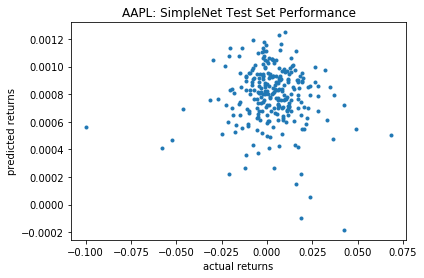

In [91]:
plt.figure()
plt.title("AAPL: SimpleNet Test Set Performance")
plt.xlabel("actual returns")
plt.ylabel("predicted returns")
plt.plot(y_test, y_pred, ls=' ', marker='.')
plt.savefig("data/figs/simpleNet-scatterplot.png", dpi=600)

In [71]:
price = 155.21400451660156

In [78]:
price_real = price * pd.Series(1 + y_test).cumprod()
price_real = np.append(np.array([price]), price_real)

price_pred = price_real[:-1] * pd.Series(1 + y_pred)
price_pred = np.append(np.array([price]), price_pred)

price_pred_no_adjust = price * pd.Series(1 + y_pred).cumprod()
price_pred_no_adjust = np.append(np.array([price]), price_pred_no_adjust)

In [81]:
price_real = pd.Series(price_real[:-1], index=df_test.index)
price_pred = pd.Series(price_pred[:-1], index=df_test.index)
price_pred_no_adjust = pd.Series(price_pred_no_adjust[:-1], index=df_test.index)

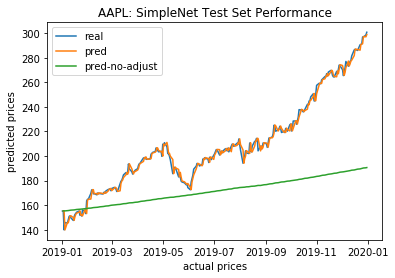

In [92]:
plt.figure()
plt.title("AAPL: SimpleNet Test Set Performance")
plt.xlabel("actual prices")
plt.ylabel("predicted prices")
plt.plot(df_test.index, price_real, label='real')
plt.plot(df_test.index[1:], price_pred[1:], label='pred')
plt.plot(df_test.index[1:], price_pred_no_adjust[1:], label='pred-no-adjust')
plt.legend()
plt.savefig("data/figs/simpleNet-test-set.png", dpi=600)

**Conclusion:**

As we can see, our model successfully predicts 57.85% of the stock price movements, but is it because the data itself is biased? Let me try in Step 3 with a better LSTM model.

In [ ]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [17]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted sagemaker-pytorch-2020-02-24-02-35-55-897
